# Diagnoza niewydolności serca

Celem projektu jest zbudowanie i porównanie kilku modeli diagnozy niewydolności serca na podstawie [zbioru danych](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction), będącego połączeniem pięciu innych zbioru danych udostępnionych przez UCI Machine Learning Repository.

Plan pracy:
- proces przetwarzania danych
- proces modelowania (znajdowania optymalnych parametrów)
- porównanie kilku modeli
- wizualizacja wyników
- podsumowanie pracy

In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [434]:
df = pd.read_csv('data/heart.csv')

Opis kolumn:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

# Przetwarzanie danych

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [436]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


Zobaczmy, czy mamy jakieś missing values w naszym zbiorze danych.

In [437]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Mamy więc brakujące pozycje w kolumnach ChestPainType, RestingBP, Cholesterol, FastingBS, MaxHR, ExerciseAngina i ST_Slope. Zajmiemy się nimi później korzystając z pipeline.

Przjrzyjmy się histogramom naszych danych:

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


C:\Users\HP\AppData\Local\Temp\ipykernel_3044\934938843.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


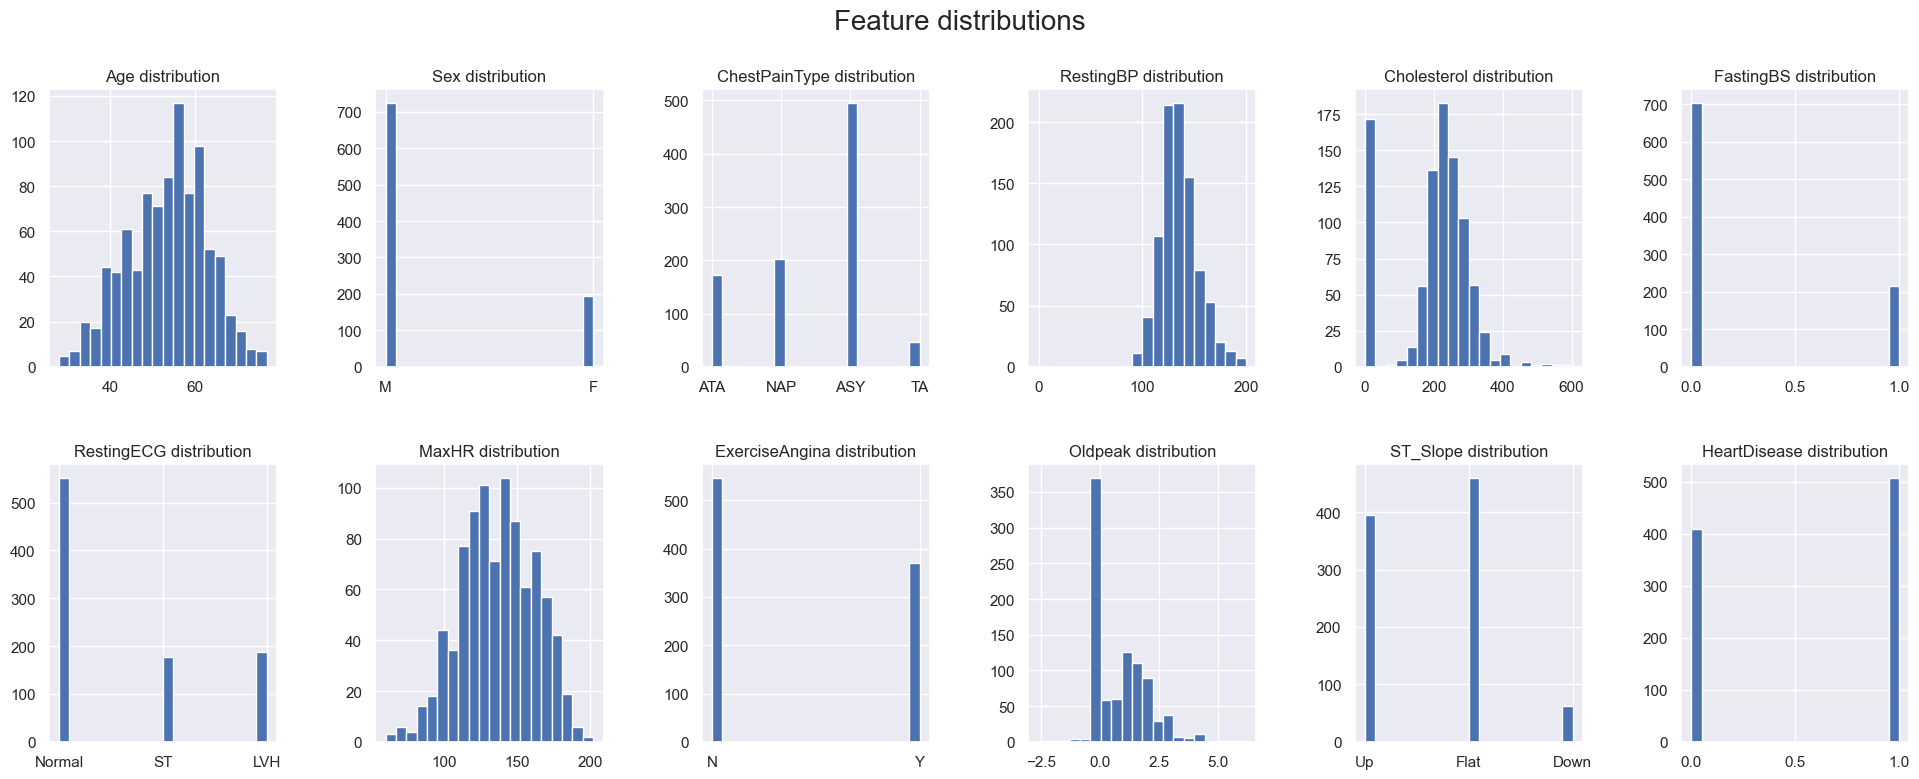

In [438]:

fig, axs = plt.subplots(2, 6, figsize=(20, 8))
i = 0
j = 0
for feature in list(df.columns):
  print(feature)
  df[feature].hist(bins=20, ax=axs[i,j])
  axs[i,j].set_title(feature + " distribution")
  j = j + 1
  if j == 6:
    i = i + 1
    j = 0  

fig.tight_layout(pad=3.0)
fig.suptitle("Feature distributions", fontsize=20, verticalalignment='bottom')
fig.show()

In [439]:
bp_ix = df[df.RestingBP == 0].index[0]
bp_median = df.RestingBP.median()
df.loc[bp_ix, 'RestingBP'] = bp_median


Teraz zobaczmy korelację kolumn.

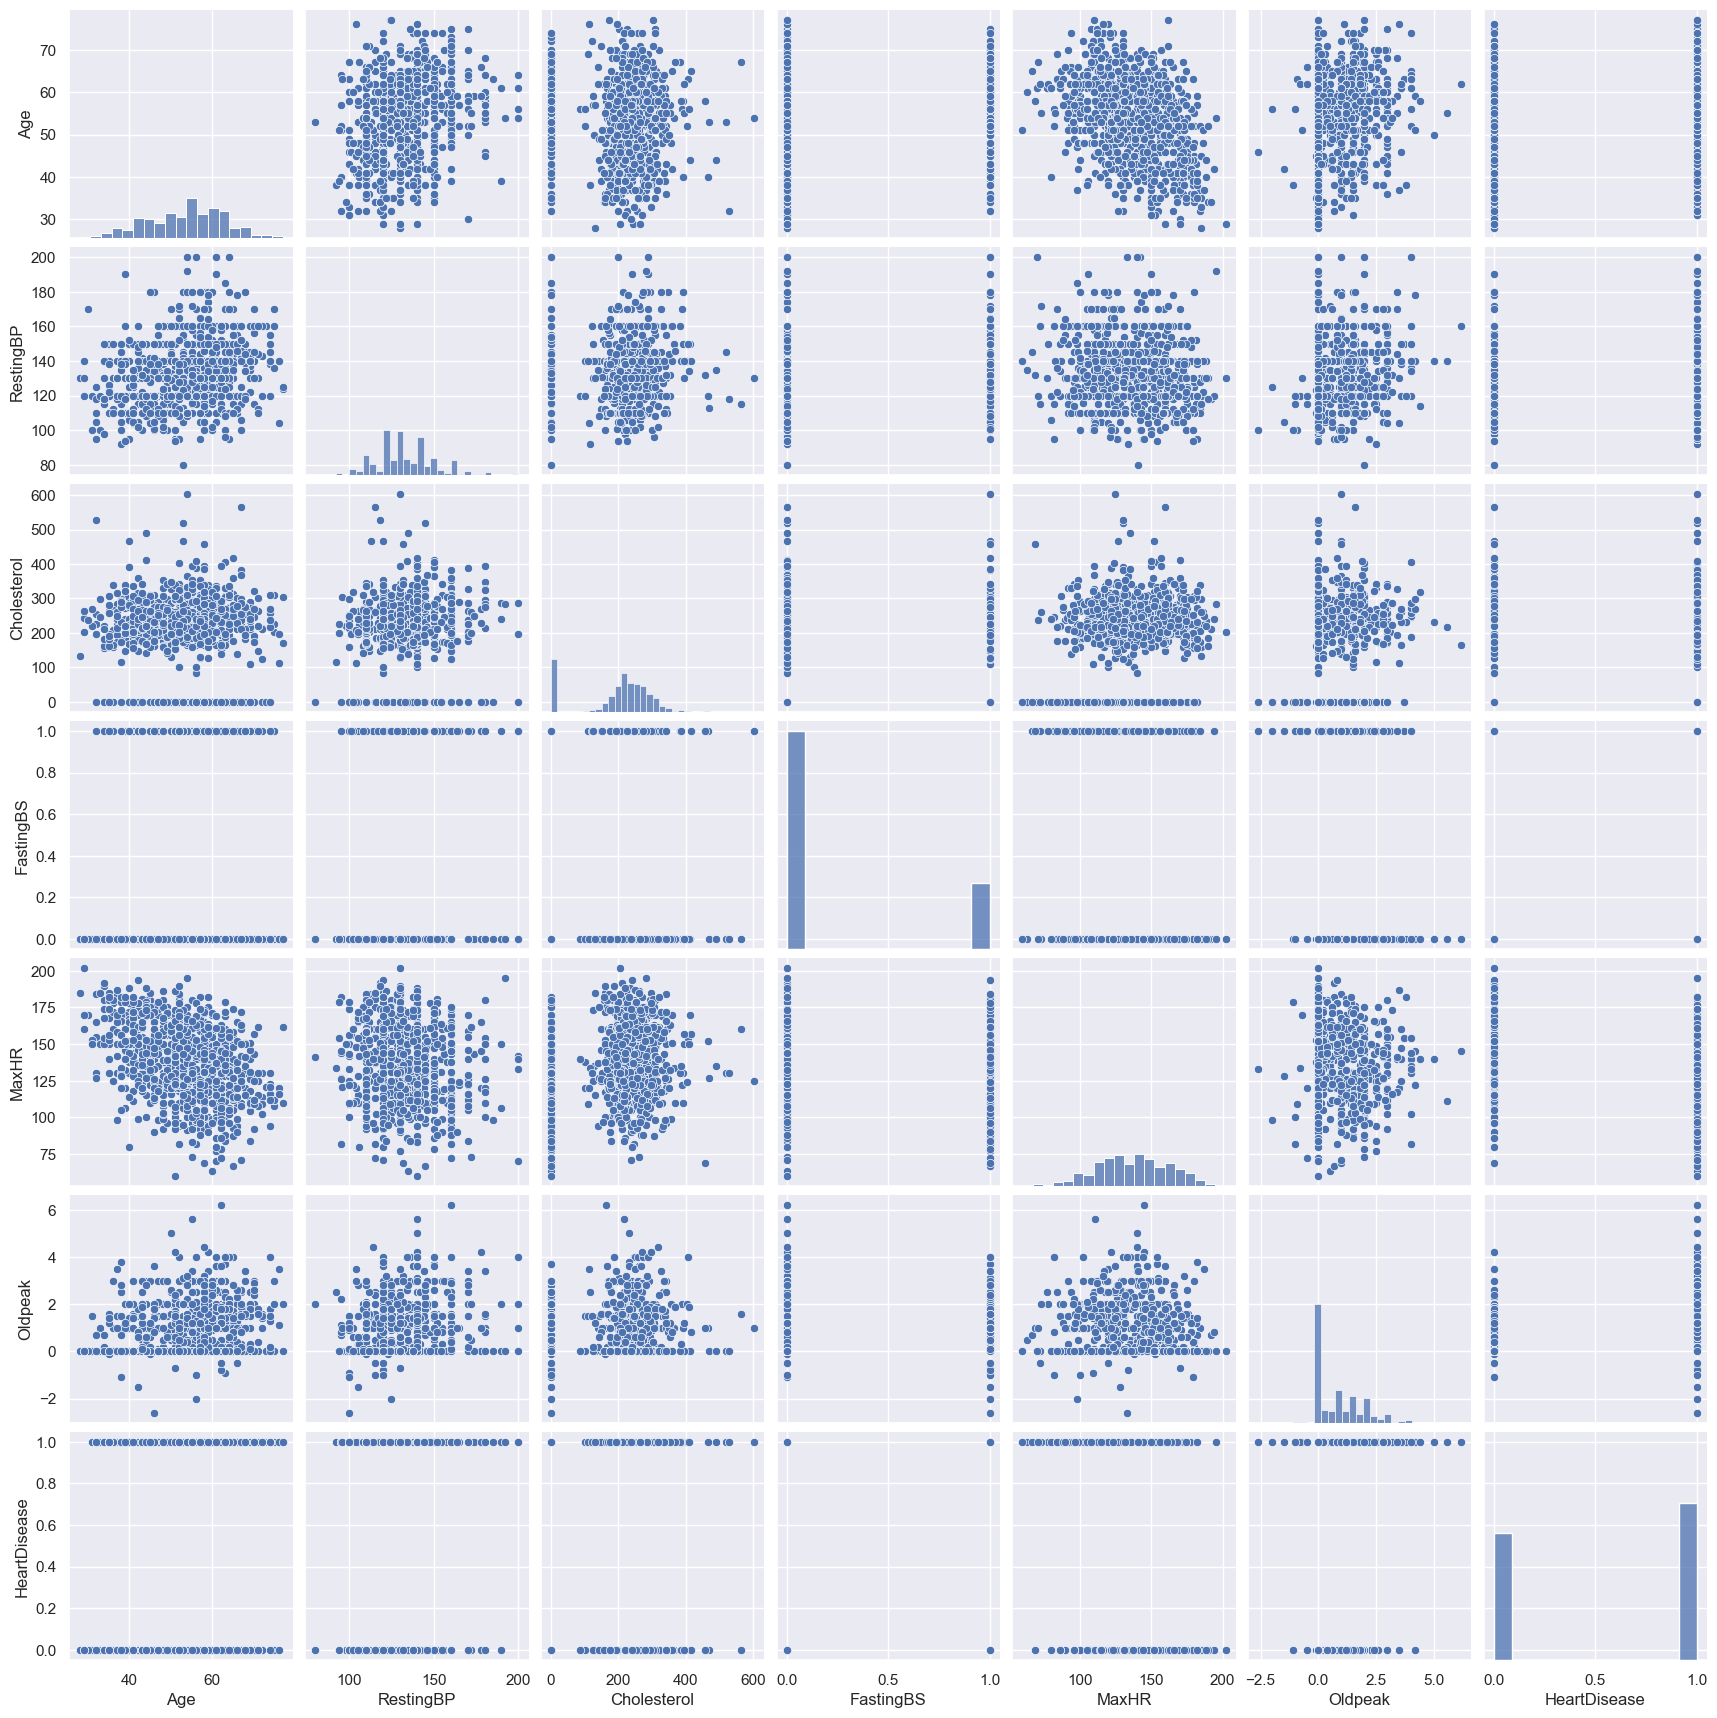

In [440]:
import seaborn as sns

sns.pairplot(df)
plt.show()

In [441]:
corr = df.loc[:, df.columns != "classification"].corr()
corr

C:\Users\HP\AppData\Local\Temp\ipykernel_3044\1862120142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.loc[:, df.columns != "classification"].corr()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.263054,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.263054,1.000000,0.089510,0.067896,-0.109771,0.174130,0.117798
Cholesterol,-0.095282,0.089510,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.067896,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.109771,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.174130,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.117798,-0.232741,0.267291,-0.400421,0.403951,1.000000


Największą korelację mamy między MaxHR i Age oraz Oldpeak i HeartDisease.

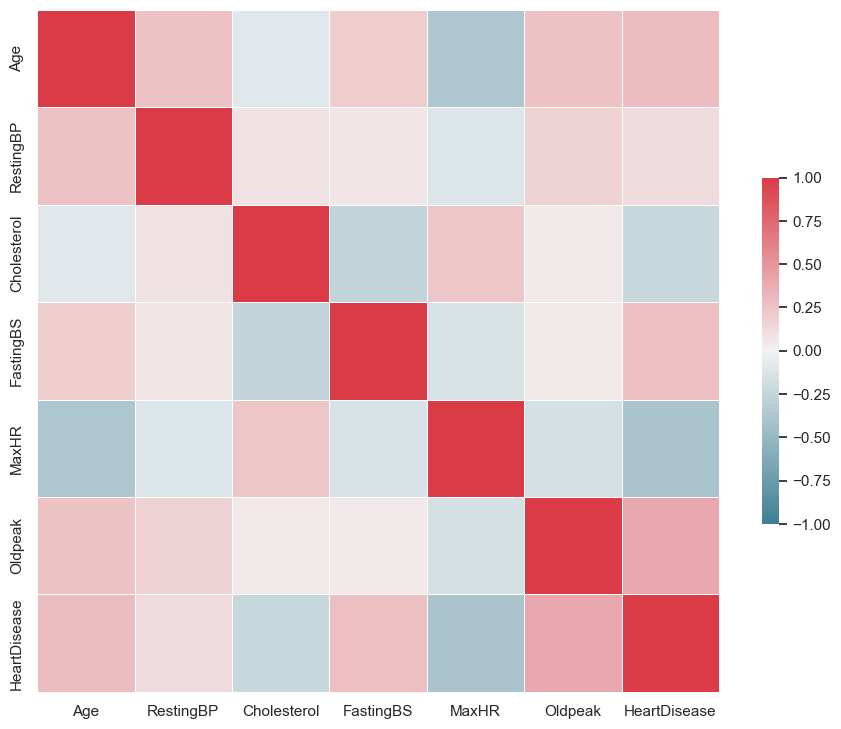

In [442]:
sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

# Modelowanie danych

Dzielimy dane na train i test.

In [443]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease'].values

In [444]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.70, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.20)


Rzućmy okiem na atrybuty kategotyczne:

In [445]:
X_train['Sex'].value_counts()

M    495
F    147
Name: Sex, dtype: int64

In [446]:
X_train['ChestPainType'].value_counts()

ASY    354
NAP    137
ATA    124
TA      27
Name: ChestPainType, dtype: int64

In [447]:
X_train['FastingBS'].value_counts()

0    503
1    139
Name: FastingBS, dtype: int64

In [448]:
X_train['RestingECG'].value_counts()

Normal    385
LVH       131
ST        126
Name: RestingECG, dtype: int64

In [449]:
X_train['ExerciseAngina'].value_counts()

N    380
Y    262
Name: ExerciseAngina, dtype: int64

In [450]:
X_train['ST_Slope'].value_counts()

Flat    329
Up      274
Down     39
Name: ST_Slope, dtype: int64

Zbudujmy pipeline preprocessingu:

In [451]:
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline dla atrybutów numerycznych. W miejsce pustych wartości wstawiamy medianę z danej kolumny.

In [452]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['RestingBP', 'Cholesterol'])),
        ("imputer", SimpleImputer(strategy="median", missing_values=0)),
    ])

other_num_pipeline = Pipeline([
    ("select_other_columns", DataFrameSelector(['Age', 'MaxHR', 'Oldpeak'])),
])

Pipeline dla atrybutów kategorycznych. W miejsce pustej wartości wstawiamy najczęściej występującą wartość z danej kolumny oraz używamy kodowania one hot.

In [453]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [454]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

Pierwszy z modeli, który weźmiemy pod uwagę to Random Forest. Będziemy używać GridSearcha, aby znaleźć najlepsze parametry.

In [455]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [456]:
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("other_num_pipeline", other_num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__random_state': [0]
}


In [457]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

grid_search1 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search1.fit(X_train, y_train)
grid_search1.best_params_
ypred = grid_search1.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [458]:
print("Accuracy: ", accuracy)

Accuracy:  0.8392857142857143


In [459]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.89      0.87      0.88        39

    accuracy                           0.84        56
   macro avg       0.81      0.82      0.81        56
weighted avg       0.84      0.84      0.84        56



<Axes: >

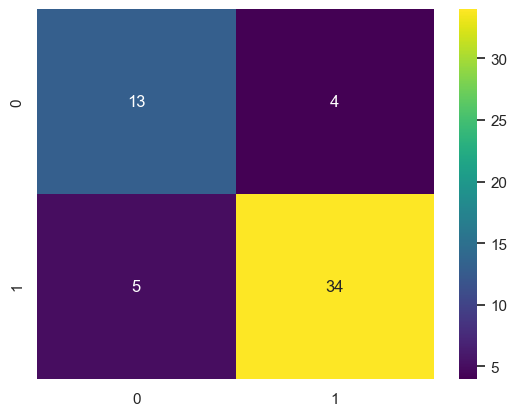

In [460]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądrem rbf:

In [461]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='rbf'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000],
}

In [462]:
grid_search2 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search2.fit(X_train, y_train)
grid_search2.best_params_
ypred = grid_search2.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [463]:
print("Accuracy: ", accuracy)

Accuracy:  0.8392857142857143


<Axes: >

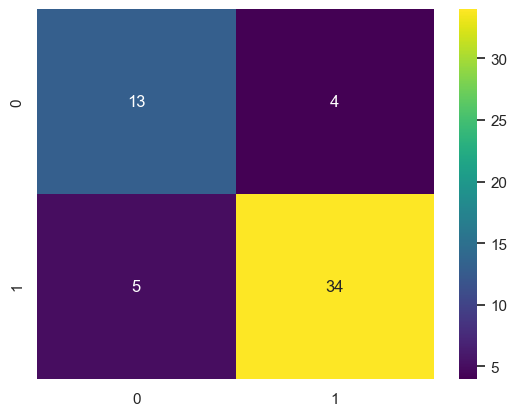

In [464]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądem poly:

In [465]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='poly'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000],
}

In [466]:
grid_search3 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search3.fit(X_train, y_train)
grid_search3.best_params_
ypred = grid_search3.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [467]:
print("Accuracy: ", accuracy)

Accuracy:  0.8571428571428571


<Axes: >

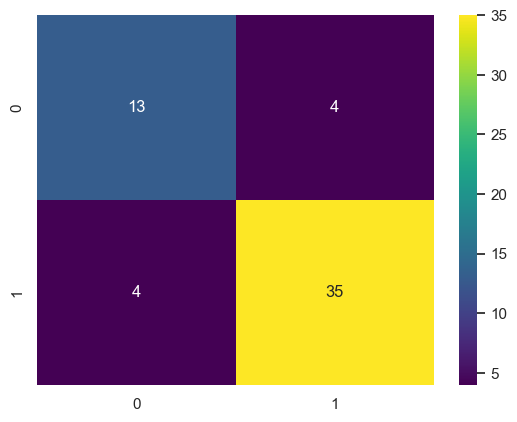

In [468]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądrem linear:

In [469]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='linear'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000]
}

In [470]:
grid_search5 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search5.fit(X_train, y_train)
grid_search5.best_params_
ypred = grid_search5.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [471]:
print("Accuracy: ", accuracy)

Accuracy:  0.8214285714285714


<Axes: >

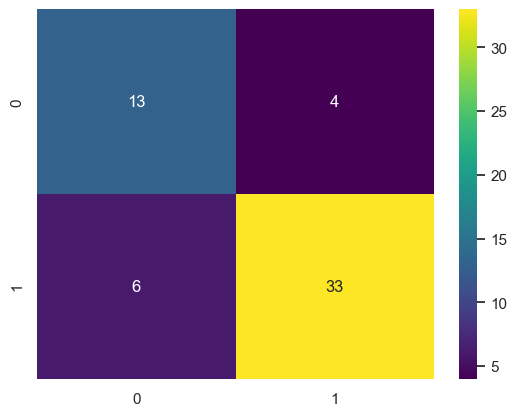

In [472]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

Regresja logistyczna:

In [473]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', LogisticRegression(n_jobs=-1))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [474]:
grid_search6 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search6.fit(X_train, y_train)
grid_search6.best_params_
ypred = grid_search6.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<Axes: >

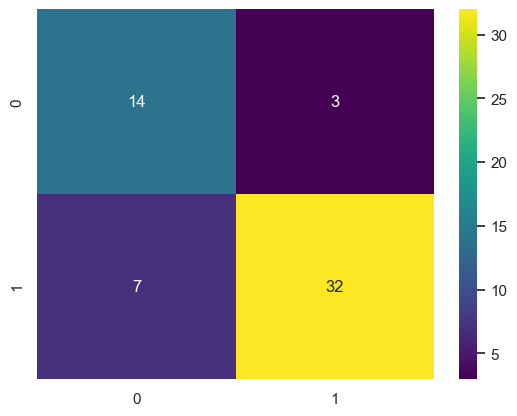

In [475]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

XGBClassifier:

In [476]:
import xgboost

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', xgboost.XGBClassifier())])

param_grid = {
    'classifier__n_estimators': [2, 5, 10, 20],
    'classifier__learning_rate': [0.5, 1, 0.1, 2]
}

In [477]:
grid_search4 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search4.fit(X_train, y_train)
grid_search4.best_params_
ypred = grid_search4.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [478]:
print("Accuracy: ", accuracy)

Accuracy:  0.7678571428571429


<Axes: >

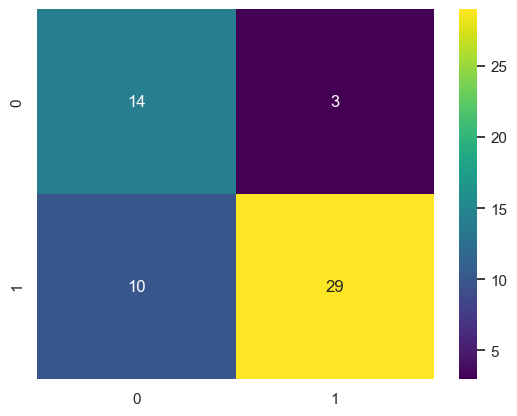

In [479]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

Porównanie wyników.

In [480]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score


models = []
models.append(('RandomForest', grid_search1.best_estimator_))
models.append(('SVM rbf', grid_search2.best_estimator_))
models.append(('SVM poly', grid_search3.best_estimator_))
models.append(('SVM linear', grid_search5.best_estimator_))
models.append(('XGBoost', grid_search4.best_estimator_))
models.append(('Logistic Regression', grid_search6.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_score = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    print("roc_score: {}".format( roc_auc_score(y_test, model.predict(X_test))))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    roc_score.append(roc_auc_score(y_test, model.predict(X_test)))

RandomForest
R^2: 0.8947368421052632
recall_score: 0.8717948717948718
f1_score: 0.8831168831168831
accuracy_score: 0.8392857142857143
roc_score: 0.8182503770739065
SVM rbf
R^2: 0.8947368421052632
recall_score: 0.8717948717948718
f1_score: 0.8831168831168831
accuracy_score: 0.8392857142857143
roc_score: 0.8182503770739065
SVM poly
R^2: 0.8974358974358975
recall_score: 0.8974358974358975
f1_score: 0.8974358974358975
accuracy_score: 0.8571428571428571
roc_score: 0.8310708898944191
SVM linear
R^2: 0.8918918918918919
recall_score: 0.8461538461538461
f1_score: 0.868421052631579
accuracy_score: 0.8214285714285714
roc_score: 0.8054298642533937
XGBoost
R^2: 0.90625
recall_score: 0.7435897435897436
f1_score: 0.8169014084507042
accuracy_score: 0.7678571428571429
roc_score: 0.7835595776772247
Logistic Regression
R^2: 0.9142857142857143
recall_score: 0.8205128205128205
f1_score: 0.8648648648648648
accuracy_score: 0.8214285714285714
roc_score: 0.8220211161387632


In [481]:
d = {
    'precision score': precision_score,
    'recall score': recall_score,
    'f1 score': f1_score,
    'accuracy score': accuracy_score,
    'roc score': roc_score 
}

df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['RandomForest', 'SVM rbf', 'SVM poly', 'SVM linear', 'XGBoost', 'Logistic Regression'])
df

,Method,precision score,recall score,f1 score,accuracy score,roc score
0,RandomForest,0.894737,0.871795,0.883117,0.839286,0.818250
1,SVM rbf,0.894737,0.871795,0.883117,0.839286,0.818250
2,SVM poly,0.897436,0.897436,0.897436,0.857143,0.831071
3,SVM linear,0.891892,0.846154,0.868421,0.821429,0.805430
4,XGBoost,0.906250,0.743590,0.816901,0.767857,0.783560
5,Logistic Regression,0.914286,0.820513,0.864865,0.821429,0.822021


Porównanie współczynników liniowych SVMa liniowego i regresji logistycznej.

In [482]:
cat_features = grid_search6.best_estimator_.named_steps["preprocessing"].transformer_list[2][1].named_steps['cat_encoder'].get_feature_names_out()
num_features = grid_search6.best_estimator_.named_steps["preprocessing"].transformer_list[0][1].named_steps['select_numeric'].attribute_names
other_num_features = grid_search6.best_estimator_.named_steps["preprocessing"].transformer_list[1][1].named_steps['select_other_columns'].attribute_names
other_num_features

IndexError: list index out of range

In [ ]:
combined_features = np.concatenate([num_features, other_num_features, cat_features])

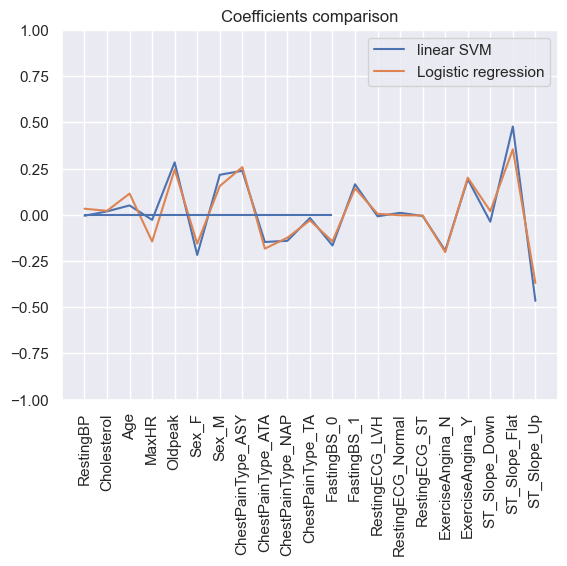

In [ ]:
plt.plot(grid_search5.best_estimator_.named_steps["classifier"].coef_.T, label="linear SVM")
plt.plot(grid_search6.best_estimator_.named_steps["classifier"].coef_.T, label="Logistic regression")
plt.xticks(range(combined_features.shape[0]), combined_features, rotation=90)
plt.hlines(0, 0, X_train.shape[1])
plt.ylim(-1, 1)
plt.legend()
plt.title("Coefficients comparison")
plt.show()

Porównanie feature importance dla XBGClassifier i Random Forest Classifier.

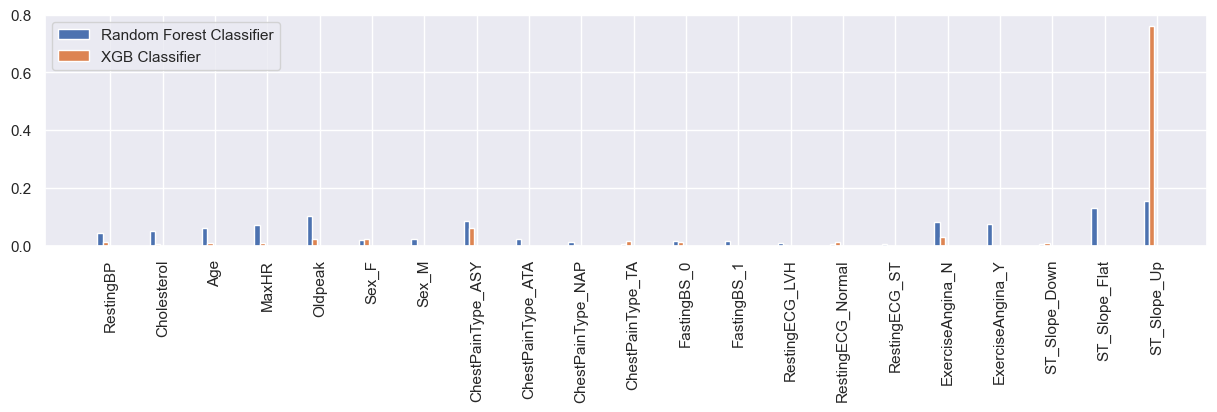

In [ ]:

fig, ax = plt.subplots(figsize=(15,3))
x = np.arange(len(combined_features))

ax.bar(x-0.2, grid_search1.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Random Forest Classifier")
ax.bar(x-0.1, grid_search4.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="XGB Classifier")

plt.xticks(x, combined_features, rotation=90)
plt.legend()
plt.show()

Widać więc, że dla obu tych klasyfikatorów najważniejszym aspektem jest ST_Slope_UP.

# Sieci neuronowe

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

In [ ]:
history = History()
model = Sequential()
model.add(Dense(32,activation="relu", input_shape=(21,)))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                704       
                                                                 
 dense_26 (Dense)            (None, 24)                792       
                                                                 
 dense_27 (Dense)            (None, 24)                600       
                                                                 
 dense_28 (Dense)            (None, 24)                600       
                                                                 
 dense_29 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])


In [ ]:
pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('model', model)])

In [ ]:
X_test.shape

(56, 11)

In [ ]:
preprocess_pipeline.fit(X_valid)
X_valid_transformed = preprocess_pipeline.transform(X_valid)
scaler = StandardScaler()
scaler.fit(X_valid_transformed)
X_valid_scaled_transformed = scaler.transform(X_valid_transformed)
X_valid_transformed[:, 1] 

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([240., 219., 197., 223., 117., 126., 240., 289., 240., 240., 240.,
       297., 240., 240., 223., 240., 180., 349., 240., 246., 311., 271.,
       240., 281., 240., 254., 240., 298., 175., 289., 248., 256., 211.,
       305., 209., 240., 268., 197., 216., 339., 241., 268., 529., 208.,
       182., 261., 260., 206., 245., 240., 269., 203., 240., 240., 230.,
       215., 214., 142., 277., 263., 204., 186., 269., 240., 266., 200.,
       219., 236., 294., 240., 147., 240., 240., 194., 240., 240., 236.,
       288., 283., 240., 160., 222., 230., 297., 263., 240., 340., 196.,
       240., 207., 219., 166., 518., 228., 341., 247., 240., 183., 240.,
       253., 214., 265., 288., 165., 208., 311., 241., 290., 240., 167.,
       169., 209., 308., 211., 234., 168., 240., 241., 272., 212., 219.,
       232., 213., 240., 240., 240., 220., 175., 240., 186., 248., 193.,
       240., 306., 315., 240., 167., 236., 240., 241., 260., 240., 226.,
       322., 231., 153., 213., 240., 139., 213., 39

In [ ]:

history = pipe.fit(X_train, y_train, model__validation_data= (X_valid_scaled_transformed, y_valid), model__batch_size=32, model__epochs=50)
# output = pipe.named_steps['preprocessing'].transform(X_train)
# scaler = StandardScaler()
# scaler.fit(output)
# output_scaled = scaler.transform(output)

# output1 = pipe.named_steps['preprocessing'].transform(X_test)
# scaler1 = StandardScaler()
# scaler1.fit(output)
# output_scaled1 = scaler1.transform(output)
# type(output_scaled[19][0])

In [ ]:
from keras.layers import Dropout

history1 = History()
model1 = Sequential()
model1.add(Dense(24,activation="relu", input_shape=(21,)))
model1.add(Dropout(0.4))
model1.add(Dense(24,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(24,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(1,activation="sigmoid"))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 24)                528       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_35 (Dense)            (None, 24)                600       
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_36 (Dense)            (None, 24)                600       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
history1 = pipe.fit(X_train, y_train, model__validation_data= (X_valid_scaled_transformed, y_valid), model__batch_size=32, model__epochs=50)

Epoch 1/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.2316 - val_accuracy: 0.8455
Epoch 2/50
 1/21 [>.............................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


21/21 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2386 - val_accuracy: 0.8455
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2339 - val_accuracy: 0.8455
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2351 - val_accuracy: 0.8455
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2523 - val_accuracy: 0.8455
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2569 - val_accuracy: 0.8455
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2587 - val_accuracy: 0.8455
Epoch 8/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2638 - val_accuracy: 0.8455
Epoch 9/50
21/21 [=============

In [ ]:
preprocess_pipeline.fit(X_test)
X_test_transformed = preprocess_pipeline.transform(X_test)
scaler = StandardScaler()
scaler.fit(X_test_transformed)
X_test_scaled_transformed = scaler.transform(X_test_transformed)

test_preds = model.predict(X_test_scaled_transformed)
test_preds = [round(float(i), 0) for i in test_preds]
test_preds1 = model1.predict(X_test_scaled_transformed)
test_preds1 = [round(float(i), 0) for i in test_preds1]

print("R^2: {}".format(metrics.precision_score(y_test, test_preds) ))
print("recall_score: {}".format( metrics.recall_score(y_test, test_preds) ))
print("f1_score: {}".format( metrics.f1_score(y_test, test_preds) ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, test_preds)) )
print("roc_score: {}".format( roc_auc_score(y_test, test_preds)))

print("R^2: {}".format(metrics.precision_score(y_test, test_preds1) ))
print("recall_score: {}".format( metrics.recall_score(y_test, test_preds1) ))
print("f1_score: {}".format( metrics.f1_score(y_test, test_preds1) ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, test_preds1)) )
print("roc_score: {}".format( roc_auc_score(y_test, test_preds1)))

2/2 [==============================] - 0s 2ms/step
R^2: 0.7777777777777778
recall_score: 0.75
f1_score: 0.7636363636363638
accuracy_score: 0.7678571428571429
roc_score: 0.7678571428571428
R^2: 0.0
recall_score: 0.0
f1_score: 0.0
accuracy_score: 0.5
roc_score: 0.5


c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
